In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# load train, test, validation splits
saved_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetection/saved_data/train_val_test_preprocessed/'

saved_dir_2 = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetection/saved_data/train_val_split/'

X_train = np.load(saved_dir + 'X_train_preprocessed.npy')

X_val = np.load(saved_dir + 'X_val_preprocessed.npy')

y_train = np.load(saved_dir_2 + 'y_train.npy')

y_val = np.load(saved_dir_2 + 'y_val.npy')

In [3]:
# pretrained model - MobileNetV2
# all should be numpy arrays or tensors before giving it to MobileNetV2
"""
    tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=None,                 # Shape of input data (MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.) 
    alpha=1.0,                        # Width multiplier for controlling network width (default is 1.0)
    include_top=True,                 # Include fully connected top layers (default is True)
    weights='imagenet',               # Weight initialization ('imagenet' for pre-trained weights, None for random initialization)
    input_tensor=None,                # Optional input tensor (default is None)
    pooling=None,                     # Pooling type for the last layer ('avg', 'max', or None; default is None)
    classes=1000,                     # Number of output classes (default is 1000 for ImageNet)
    classifier_activation='softmax',   # Activation function for output layer (default is 'softmax')
    **kwargs                          # Additional keyword arguments
    )
"""
# we dont have to set anything and keep its default values
MobileNetV2_model = tf.keras.applications.mobilenet_v2.MobileNetV2()
    
# Make all layers in the model non-trainable - freeze
for layer in MobileNetV2_model.layers:
    layer.trainable = False

# for reproducability - can be used between different runtimes
tf.random.set_seed(0)

# Get the base model's input and output
base_input = MobileNetV2_model.layers[0].input
base_output = MobileNetV2_model.layers[-3].output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_output)

dense_layer = tf.keras.layers.Dense(160, activation='relu')(global_average_layer) 
dropout_layer = tf.keras.layers.Dropout(0.2)(dense_layer)
final_output = tf.keras.layers.Dense(10)(dropout_layer)
final_output = tf.keras.layers.Activation("softmax")(final_output)

In [6]:
distraction_detection_model = tf.keras.Model(
    inputs=base_input,
    outputs=final_output
)

In [8]:
# one hot encoding the lebels
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=10)
y_val_encoded = to_categorical(y_val, num_classes=10)
y_train_encoded, y_val_encoded

(array([[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32))

In [9]:
# Compile and train the model using X_train - preprocessed as input
initial_learning_rate = 0.0001

# Use the ReduceLROnPlateau learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
)

distraction_detection_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
                                   loss='categorical_crossentropy', 
                                   metrics=['accuracy'])

history_of_model = distraction_detection_model.fit(
                               X_train, 
                               y_train_encoded, 
                               epochs=50, 
                               batch_size=32, 
                               validation_data=(X_val, y_val_encoded),
                               callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), lr_scheduler])

Epoch 1/50
631/631 [==============================] - 332s 521ms/step - loss: 1.4836 - accuracy: 0.5285 - val_loss: 0.7973 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 2/50
631/631 [==============================] - 359s 570ms/step - loss: 0.6830 - accuracy: 0.8247 - val_loss: 0.4607 - val_accuracy: 0.9108 - lr: 1.0000e-04
Epoch 3/50
631/631 [==============================] - 368s 584ms/step - loss: 0.4344 - accuracy: 0.8925 - val_loss: 0.3243 - val_accuracy: 0.9309 - lr: 1.0000e-04
Epoch 4/50
631/631 [==============================] - 367s 582ms/step - loss: 0.3169 - accuracy: 0.9234 - val_loss: 0.2609 - val_accuracy: 0.9447 - lr: 1.0000e-04
Epoch 5/50
631/631 [==============================] - 433s 686ms/step - loss: 0.2469 - accuracy: 0.9409 - val_loss: 0.2029 - val_accuracy: 0.9559 - lr: 1.0000e-04
Epoch 6/50
631/631 [==============================] - 447s 709ms/step - loss: 0.1988 - accuracy: 0.9540 - val_loss: 0.1753 - val_accuracy: 0.9639 - lr: 1.0000e-04
Epoch 7/50
631/631 [==

In [10]:
training_loss = history_of_model.history['loss']
validation_loss = history_of_model.history['val_loss']

training_accuracy = history_of_model.history['accuracy']
validation_accuracy = history_of_model.history['val_accuracy']

# Calculate the number of training epochs:
# - `len(training_loss)` calculates the length of the training_loss list, which typically
#   contains the loss value at the end of each training epoch.
# - This length tells us how many epochs the machine learning model was trained for.

# Create a range of values representing epochs:
# - `range(1, len(training_loss) + 1)` generates a Python range object starting from 1 and
#   ending at the length of the training_loss list plus one.
# - The +1 is added to ensure that the range includes values up to the number of epochs.
# - This range is often used as the x-axis when plotting training metrics against the
#   number of training iterations (epochs).
epochs = range(1, len(training_loss) + 1)

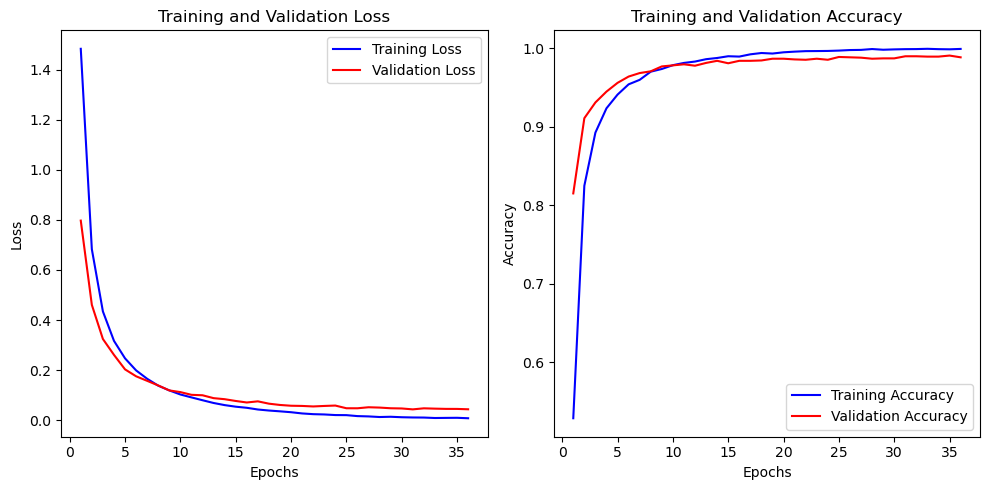

In [11]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# free up memory
del X_train
del X_val
del y_train
del y_val

In [12]:
# Save the model architecture and weights
save_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetection/saved_data/models/'

distraction_detection_model.save(save_dir + 'dis_det_model.h5')

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Save the history object to a file
with open(save_dir + 'dis_det_model_history.pkl', 'wb') as file:
    pickle.dump(history_of_model.history, file)